### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Lets test different spectral cleaning parameters

Import Libraries

In [32]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [33]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [34]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


Filter the effective range from 400 to 1800 cm-1

In [35]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239205 entries, 293 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 333.2+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [37]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [38]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [39]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1216.4025,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1339.4675,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1996.8234,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,2010.1119,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2001.0719,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,Normal


>Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with 10-fold cross validation.

In [40]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [41]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8394 +/- 0.0128


>Scale the absorbances to the highest peak in each spectrum.

In [42]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

/tmp/ipykernel_12250/3971180955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))


In [43]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755
...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325


In [44]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [45]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8371 +/- 0.0213


> Now see the effect of spikes caused by cosmic rays

Locate and correct the spikes

In [46]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

/tmp/ipykernel_12250/1664972360.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))


In [47]:
df  

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,1765.6628
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,1774.7809
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,1769.0302
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,1756.4220
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,1758.8690
...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079,1617.3926
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651,1633.0911
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742,1633.3076
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325,1641.8665


In [48]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [49]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8410 +/- 0.0146


Despike with scaling.

In [50]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

/tmp/ipykernel_12250/925724277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))


In [51]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [52]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8407 +/- 0.0182


Seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [53]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Here is an example on 1 spectrum

In [54]:
sample = df[df['SpecID'] == "210526-3-09"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8021233,210526-3-09,293,400.22778,2177.7354,210526-3,Hyperglycemia,0.911652,2177.7354,0.911652
8021234,210526-3-09,294,400.91116,2164.6213,210526-3,Hyperglycemia,0.906162,2164.6213,0.906162
8021235,210526-3-09,295,401.59454,2158.2505,210526-3,Hyperglycemia,0.903496,2158.2505,0.903496
8021236,210526-3-09,296,402.27789,2153.8586,210526-3,Hyperglycemia,0.901657,2153.8586,0.901657
8021237,210526-3-09,297,402.96127,2141.1379,210526-3,Hyperglycemia,0.896332,2141.1379,0.896332
...,...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079,1617.3926,0.677079
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651,1633.0911,0.683651
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742,1633.3076,0.683742
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325,1641.8665,0.687325


/tmp/ipykernel_12250/1293342067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

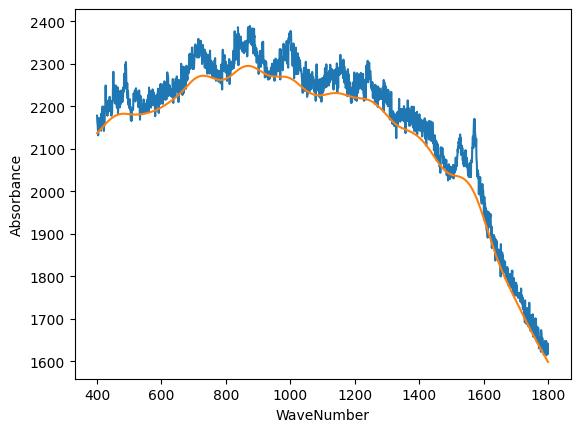

In [55]:
lam = 10 ** 5
p = 0.01
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_12250/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

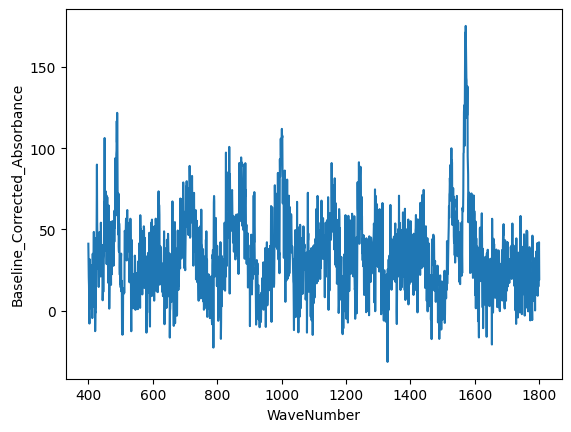

In [56]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering

In [57]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

KeyError: 'Column not found: Baseline_Corrected_Absorbance'

Scale the absorbances of each spectra by the max value.

In [ ]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

Try Min Max Scaling

## 1 Sample Example

In [ ]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Despiked_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [ ]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'], distance=152, prominence=42/3200, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

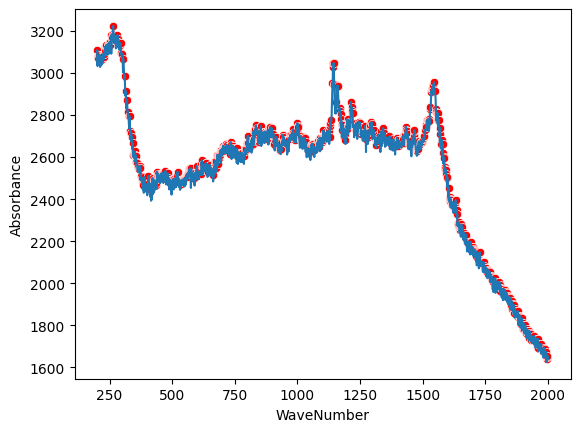

In [ ]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

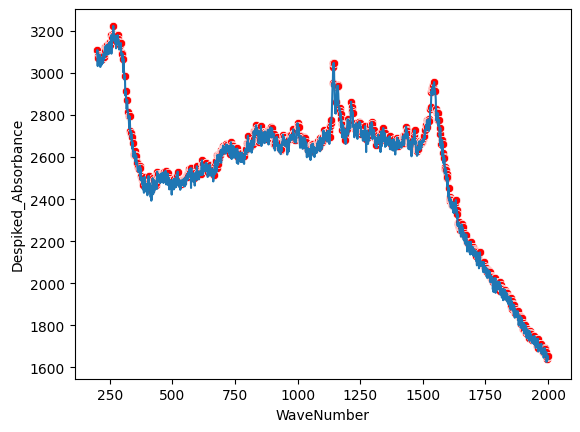

In [ ]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

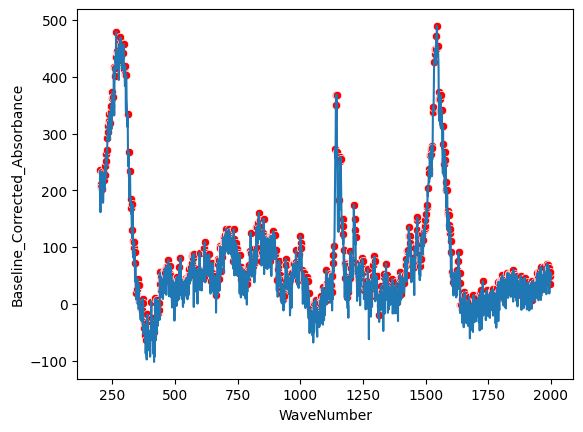

In [ ]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

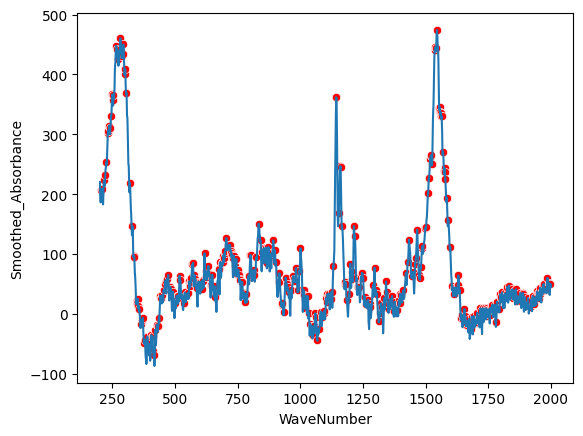

In [ ]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

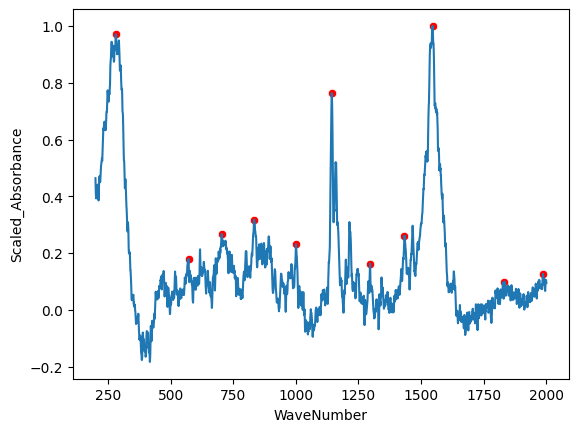

In [ ]:
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[normalised_peaks], x="WaveNumber", y="Scaled_Absorbance", color="red")

The average baseline corrected spectrum of each status

<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

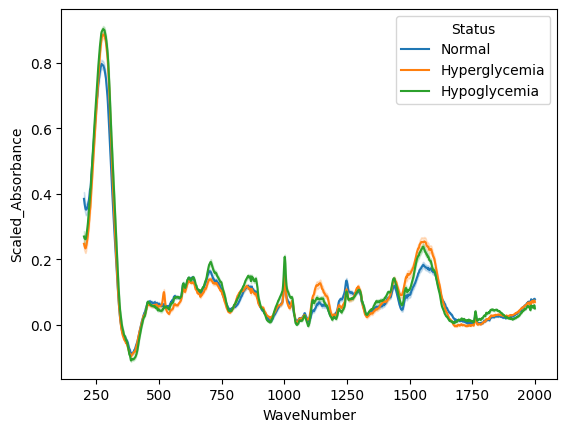

In [ ]:
sns.lineplot(data=df, x='WaveNumber', y='Scaled_Absorbance', hue='Status')

#### Machine Learning

In [ ]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [ ]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

In [ ]:
spectra_df.to_csv("../../data/scaled_and_noise_removal.csv")

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [ ]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [ ]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [ ]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.982870,0.966481,0.950833,0.935925,0.927346,0.902431,0.889797,0.880243,0.864841,...,0.070690,0.082414,0.090970,0.092890,0.083230,0.082239,0.082605,0.084328,0.087409,Normal
201210-1-01,1.000000,0.980550,0.964007,0.950373,0.939647,0.930871,0.928574,0.925606,0.914910,0.900030,...,0.113337,0.117351,0.131463,0.146428,0.158236,0.161601,0.160516,0.154980,0.144994,Normal
201210-1-02,0.502527,0.491051,0.479540,0.467993,0.456410,0.450161,0.431959,0.424441,0.417415,0.408823,...,0.144569,0.141991,0.139207,0.144627,0.149526,0.150847,0.150600,0.148786,0.145404,Normal
201210-1-03,0.492251,0.418315,0.375666,0.364304,0.384230,0.461173,0.570848,0.577491,0.675831,0.807648,...,0.005644,0.007747,0.008992,0.010157,0.011991,0.011822,0.010642,0.008451,0.005248,Normal
201210-1-04,1.000000,0.994372,0.989487,0.985346,0.981948,0.976845,0.970762,0.977536,0.981513,0.963198,...,0.019359,0.028442,0.041845,0.058730,0.063852,0.070008,0.074530,0.077417,0.078669,Normal


In [ ]:
wavelength_df.to_csv("../../data/pivoted_scaled_and_noise_removal.csv")

##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [ ]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [ ]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [ ]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8975 +/- 0.0164
ExtraTreesClassifier Cross-Validation Accuracy: 0.9156 +/- 0.0143


#### 2. Using Peak Statistics

This uses statistical properties of the peaks in each sample to be used as additional features.

In [ ]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [ ]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
728,201210-1-00,728,697.49432,201210-1,Normal,0.416662
1025,201210-1-00,1025,900.45557,201210-1,Normal,0.258440
1368,201210-1-00,1368,1134.85190,201210-1,Normal,0.075999
1535,201210-1-00,1535,1248.97500,201210-1,Normal,0.098604
1818,201210-1-00,1818,1442.36900,201210-1,Normal,0.159095
...,...,...,...,...,...,...
8009580,210526-3-49,1815,1440.31880,210526-3,Hyperglycemia,0.246373
8009759,210526-3-49,1994,1562.64230,210526-3,Hyperglycemia,0.253753
8009935,210526-3-49,2170,1682.91580,210526-3,Hyperglycemia,0.074500
8010192,210526-3-49,2427,1858.54210,210526-3,Hyperglycemia,0.111614


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

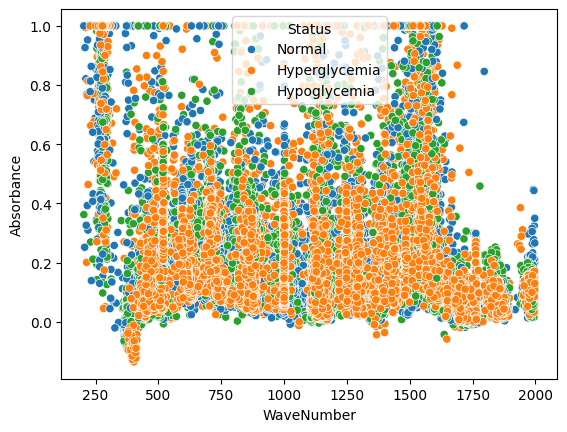

In [ ]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

In [ ]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

31274
31274
31274


/tmp/ipykernel_9499/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_9499/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [ ]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
728,201210-1-00,728,697.49432,201210-1,Normal,0.416662,50.417502,0.467156
1025,201210-1-00,1025,900.45557,201210-1,Normal,0.258440,105.946404,0.298132
1368,201210-1-00,1368,1134.85190,201210-1,Normal,0.075999,6.930531,0.096200
1535,201210-1-00,1535,1248.97500,201210-1,Normal,0.098604,18.228000,0.106020
1818,201210-1-00,1818,1442.36900,201210-1,Normal,0.159095,57.630636,0.187080


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [ ]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [ ]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [ ]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,0.185090,0.123642,7,0.416662,0.075633,58.485163,55.601911,157.694038,6.930531,0.213417,0.136056,0.467156,0.096200,Normal
201210-1-01,0.188062,0.134741,10,0.402471,0.031136,34.552204,20.341779,63.737315,8.659581,0.211695,0.151269,0.442967,0.030212,Normal
201210-1-02,0.252664,0.342481,8,1.000000,0.028898,28.528624,13.341042,49.245944,11.772012,0.261436,0.353818,1.024313,0.036799,Normal
201210-1-03,0.243610,0.320099,8,1.000000,0.011753,33.354770,19.046291,60.461061,7.375908,0.201162,0.202176,0.635696,0.015052,Normal
201210-1-04,0.212824,0.123758,11,0.488523,0.081889,42.748288,39.378109,146.361886,10.880825,0.223921,0.148798,0.528680,0.074403,Normal


In [ ]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.6184 +/- 0.0193
ExtraTreesClassifier Cross-Validation Accuracy: 0.6177 +/- 0.0223


Combine these peak statistics with the full wavelength

In [ ]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [ ]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.185090,0.123642,7,0.416662,0.075633,58.485163,55.601911,157.694038,6.930531,0.213417,...,0.061287,0.070690,0.082414,0.090970,0.092890,0.083230,0.082239,0.082605,0.084328,0.087409
201210-1-01,0.188062,0.134741,10,0.402471,0.031136,34.552204,20.341779,63.737315,8.659581,0.211695,...,0.118353,0.113337,0.117351,0.131463,0.146428,0.158236,0.161601,0.160516,0.154980,0.144994
201210-1-02,0.252664,0.342481,8,1.000000,0.028898,28.528624,13.341042,49.245944,11.772012,0.261436,...,0.143152,0.144569,0.141991,0.139207,0.144627,0.149526,0.150847,0.150600,0.148786,0.145404
201210-1-03,0.243610,0.320099,8,1.000000,0.011753,33.354770,19.046291,60.461061,7.375908,0.201162,...,0.007223,0.005644,0.007747,0.008992,0.010157,0.011991,0.011822,0.010642,0.008451,0.005248
201210-1-04,0.212824,0.123758,11,0.488523,0.081889,42.748288,39.378109,146.361886,10.880825,0.223921,...,0.012094,0.019359,0.028442,0.041845,0.058730,0.063852,0.070008,0.074530,0.077417,0.078669


In [ ]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8890 +/- 0.0172
ExtraTreesClassifier Cross-Validation Accuracy: 0.9195 +/- 0.0125


#### 3. Creating a uniform Peak Featureset

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [ ]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [ ]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

31274
31274
31274


/tmp/ipykernel_9499/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_9499/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [ ]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
728,201210-1-00,728,697.49432,201210-1,Normal,0.416662,50.417502,0.467156
1025,201210-1-00,1025,900.45557,201210-1,Normal,0.258440,105.946404,0.298132
1368,201210-1-00,1368,1134.85190,201210-1,Normal,0.075999,6.930531,0.096200
1535,201210-1-00,1535,1248.97500,201210-1,Normal,0.098604,18.228000,0.106020
1818,201210-1-00,1818,1442.36900,201210-1,Normal,0.159095,57.630636,0.187080


Assign Peaks to bins of a fixed wavelength interval.

In [ ]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_9499/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [ ]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
728,201210-1-00,728,697.49432,201210-1,Normal,0.416662,50.417502,0.467156,675-700
1025,201210-1-00,1025,900.45557,201210-1,Normal,0.258440,105.946404,0.298132,900-925
1368,201210-1-00,1368,1134.85190,201210-1,Normal,0.075999,6.930531,0.096200,1125-1150
1535,201210-1-00,1535,1248.97500,201210-1,Normal,0.098604,18.228000,0.106020,1225-1250
1818,201210-1-00,1818,1442.36900,201210-1,Normal,0.159095,57.630636,0.187080,1425-1450


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [ ]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

/tmp/ipykernel_9499/2531638340.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [ ]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,False,False,False,0.075999,False,False,False,0.098604,...,False,False,False,False,False,105.946404,False,False,False,Normal
201210-1-01,0.167134,False,False,False,False,0.088739,False,False,False,False,...,False,False,False,False,57.790541,False,False,False,False,Normal
201210-1-02,False,0.102215,False,False,False,False,False,False,False,0.035293,...,False,False,False,False,False,24.20625,False,False,False,Normal
201210-1-03,False,False,False,False,False,False,0.110097,False,False,False,...,False,False,False,False,False,56.005896,False,False,False,Normal
201210-1-04,0.213213,False,False,False,False,False,False,0.135738,False,False,...,False,False,False,52.106928,False,False,False,False,False,Normal


In [ ]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7905 +/- 0.0151
ExtraTreesClassifier Cross-Validation Accuracy: 0.7882 +/- 0.0231


Merge with the full spectrum.

In [ ]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [ ]:
bins_and_spectrum.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,False,False,False,0.075999,False,False,False,0.098604,...,0.061287,0.070690,0.082414,0.090970,0.092890,0.083230,0.082239,0.082605,0.084328,0.087409
201210-1-01,0.167134,False,False,False,False,0.088739,False,False,False,False,...,0.118353,0.113337,0.117351,0.131463,0.146428,0.158236,0.161601,0.160516,0.154980,0.144994
201210-1-02,False,0.102215,False,False,False,False,False,False,False,0.035293,...,0.143152,0.144569,0.141991,0.139207,0.144627,0.149526,0.150847,0.150600,0.148786,0.145404
201210-1-03,False,False,False,False,False,False,0.110097,False,False,False,...,0.007223,0.005644,0.007747,0.008992,0.010157,0.011991,0.011822,0.010642,0.008451,0.005248
201210-1-04,0.213213,False,False,False,False,False,False,0.135738,False,False,...,0.012094,0.019359,0.028442,0.041845,0.058730,0.063852,0.070008,0.074530,0.077417,0.078669


In [ ]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8893 +/- 0.0162
ExtraTreesClassifier Cross-Validation Accuracy: 0.9140 +/- 0.0169


In [ ]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.8893 +/- 0.0162
Top 10 Features: Index(['999.54443', '1000.2278', '1000.9111', '997.49432', '998.86102',
       '1001.5945', '329.15717', '323.00684', '299.77222', '304.55582'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.9140 +/- 0.0169
Top 10 Features: Index(['293.62186', '325.05695', '299.08884', '306.60593', '305.92255',
       '321.64011', '315.48975', '1001.5945', '300.45557', '999.54443'],
      dtype='object')
